In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import unicodedata
import nltk

import os
import time
import re

import acquire
import prepare

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-whitegrid')
sns.set_palette('twilight')
# sns.color_palette("cubehelix", as_cmap=True)
plt.rc('font', size=16)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Removing non-english strings

In [2]:
# def isEnglish(s):
#     try:
#         s.encode(encoding='utf-8').decode('ascii')
        
#     except UnicodeDecodeError:
#         return False
#     else:
#         return True

In [3]:
## testing function
#isEnglish(df.readme_contents[3])

In [4]:
# df[df.readme_contents.apply(isEnglish) == True]

# Importing clean data

In [5]:
# importing csv and reading to df

csv = 'NLP.csv'

df = pd.read_csv(csv)

df.head()

,Unnamed: 0,repo,language,readme_contents,clean,stemmed,lemmatized
0,0,python-discord/bot,Python,# Python Utility Bot\n\n[![Discord][7]][8]\n[!...,python utility bot discord78 lint test12 build...,python util bot discord78 lint test12 build34 ...,python util bot discord78 lint test12 build34 ...
1,4,microsoft/BotBuilder-Samples,JavaScript,\r\n# ![Bot Framework Samples](./docs/media/Bo...,bot framework samplesdocsmediabotframeworksamp...,bot framework samplesdocsmediabotframeworksamp...,bot framework samplesdocsmediabotframeworksamp...
2,5,GAwesomeBot/bot,JavaScript,# GAwesomeBot\n[![Travis Status](https://travi...,gawesomebot travis statushttpstravisciorggilbe...,gawesomebot travi statushttpstravisciorggilber...,gawesomebot travi statushttpstravisciorggilber...
3,6,roughike/BottomBar,Java,# BottomBar (Deprecated)\n\nI don't have time ...,bottombar deprecated dont time maintain anymor...,bottombar deprec dont time maintain anymor bas...,bottombar deprec dont time maintain anymor bas...
4,7,mithun-prasad/Bot,C#,# Developing and Deploying Intelligent Chat Bo...,developing deploying intelligent chat bots tra...,develop deploy intellig chat bot train resourc...,develop deploy intellig chat bot train resourc...


## Univariate Analysis of Target Frequency

In [6]:
# language counts
df.groupby('language').agg('count')['lemmatized'].sort_values(ascending = False)

language
Python        110
JavaScript     55
Java           24
C#             19
TypeScript     17
Name: lemmatized, dtype: int64

In [7]:
# language frequency
df.language.value_counts(normalize = True)

Python        0.491228
JavaScript    0.241228
Java          0.105263
C#            0.087719
TypeScript    0.074561
Name: language, dtype: float64

In [8]:
# grouping the data by language and looking at the distribution of languages
df_lang_freq = pd.DataFrame(df.groupby('language').agg('count')['lemmatized'])\
            .rename(columns = {'lemmatized':'count'}).sort_values(by = 'count', ascending = False)

# adding frequency column to df
df_lang_freq['freq'] = df.language.value_counts(normalize = True).round(2)

# view df
df_lang_freq

,count,freq
language,,
Python,110,0.49
JavaScript,55,0.24
Java,24,0.11
C#,19,0.09
TypeScript,17,0.07


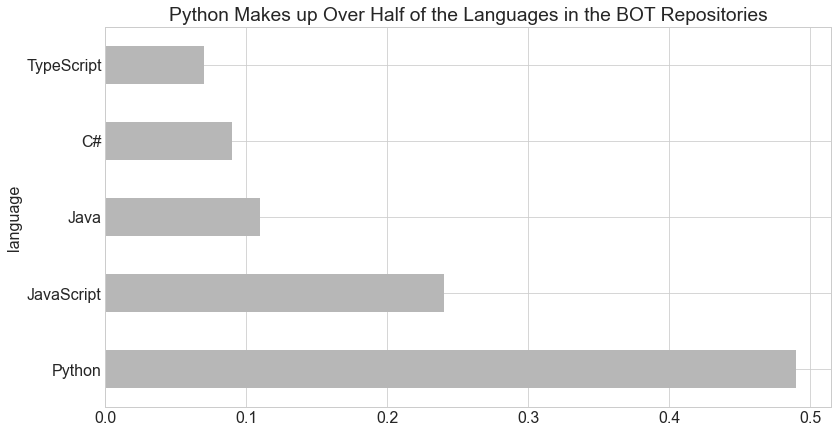

In [9]:
df_lang_freq.freq.plot.barh(color = '#b7b7b7ff')
plt.title('Python Makes up Over Half of the Languages in the BOT Repositories')
plt.show();

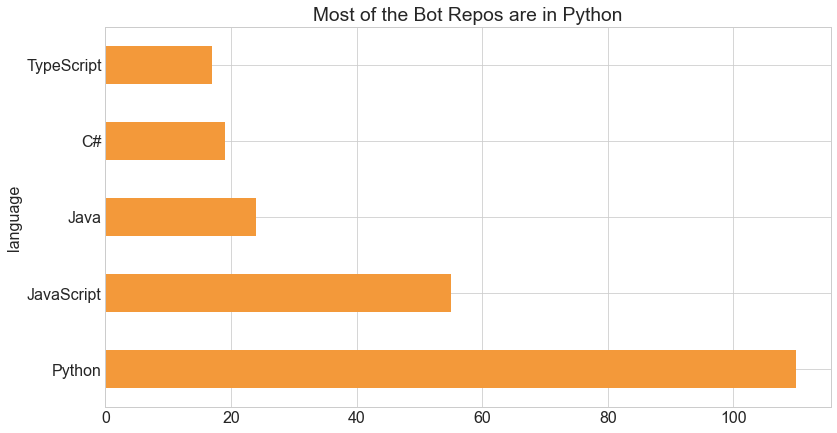

In [10]:
# plotting the language distribution of the data
df_lang_freq['count'].plot.barh(color = '#f3993aff')
plt.title('Most of the Bot Repos are in Python')
plt.show()

# Takeaways
- **Python** is the most represented of all of the languages
- **JavaScript** is the next most represented making up about half as many as **Python**
- The remaining 3: **Java**, **C#**, and **TypeScript** have close to the same count

# Splitting data

In [11]:
# calling split function from prepare module 
train, validate, test = prepare.split_data(df)

In [12]:
# verifying size of each df
train.shape, validate.shape, test.shape

((127, 7), (55, 7), (46, 7))

In [13]:
# previewing train
train.head()

,Unnamed: 0,repo,language,readme_contents,clean,stemmed,lemmatized
222,580,botgram/botgram,JavaScript,[![Botgram](./docs/splash.png)](https://botgra...,botgramdocssplashpnghttpsbotgramjsorg bots spe...,botgramdocssplashpnghttpsbotgramjsorg bot spec...,botgramdocssplashpnghttpsbotgramjsorg bot spec...
97,244,odysseusmax/animated-lamp,Python,# [Screenshotit_bot](https://tx.me/screenshoti...,screenshotit_bothttpstxmescreenshotit_bot tele...,screenshotit_bothttpstxmescreenshotit_bot tele...,screenshotit_bothttpstxmescreenshotit_bot tele...
182,479,agermanidis/SnapchatBot,Python,<h1 style='color: red'>This repo is deprecated...,h1 stylecolor redthis repo deprecated due chan...,h1 stylecolor redthi repo deprec due chang sna...,h1 stylecolor redthi repo deprec due chang sna...
108,270,NotSoSuper/NotSoBot,Python,# NotSoBot\n### Requires:\n- Python 3.5\n- [di...,notsobot requires python 35 discordpyhttpsgith...,notsobot requir python 35 discordpyhttpsgithub...,notsobot requir python 35 discordpyhttpsgithub...
176,467,boto/boto3-sample,Python,=========================\nBoto 3 Sample Appli...,boto 3 sample application application implemen...,boto 3 sampl applic applic implement drop vide...,boto 3 sampl applic applic implement drop vide...


In [14]:
# dropping the duplicate index col

for df in train, validate, test:
    df.drop(columns = ['Unnamed: 0'], inplace = True)

In [15]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
222,botgram/botgram,JavaScript,[![Botgram](./docs/splash.png)](https://botgra...,botgramdocssplashpnghttpsbotgramjsorg bots spe...,botgramdocssplashpnghttpsbotgramjsorg bot spec...,botgramdocssplashpnghttpsbotgramjsorg bot spec...
97,odysseusmax/animated-lamp,Python,# [Screenshotit_bot](https://tx.me/screenshoti...,screenshotit_bothttpstxmescreenshotit_bot tele...,screenshotit_bothttpstxmescreenshotit_bot tele...,screenshotit_bothttpstxmescreenshotit_bot tele...
182,agermanidis/SnapchatBot,Python,<h1 style='color: red'>This repo is deprecated...,h1 stylecolor redthis repo deprecated due chan...,h1 stylecolor redthi repo deprec due chang sna...,h1 stylecolor redthi repo deprec due chang sna...
108,NotSoSuper/NotSoBot,Python,# NotSoBot\n### Requires:\n- Python 3.5\n- [di...,notsobot requires python 35 discordpyhttpsgith...,notsobot requir python 35 discordpyhttpsgithub...,notsobot requir python 35 discordpyhttpsgithub...
176,boto/boto3-sample,Python,=========================\nBoto 3 Sample Appli...,boto 3 sample application application implemen...,boto 3 sampl applic applic implement drop vide...,boto 3 sampl applic applic implement drop vide...


## Word Frequency Exploration

In [16]:
list(train.language.unique())

['JavaScript', 'Python', 'TypeScript', 'C#', 'Java']

In [17]:
# combining the text strings for each language

# creating dfs
df_python = train[train.language == 'Python']
df_js = train[train.language == 'JavaScript']
df_java = train[train.language == 'Java']
df_c = train[train.language == 'C#']
df_type = train[train.language == 'TypeScript']

In [18]:
# generating text strings for each df
all_words = ' '.join(train.lemmatized.astype(str))
python_words = ' '.join(df_python.lemmatized.astype(str))
js_words = ' '.join(df_js.lemmatized.astype(str))
java_words = ' '.join(df_java.lemmatized.astype(str))
c_words = ' '.join(df_c.lemmatized.astype(str))
type_words = ' '.join(df_type.lemmatized.astype(str))

In [19]:
# looking at the joined words (preview)

print(f'All Words {len(all_words)}\nPreview:\n{all_words[:250]}')
print()
print(f'Python Words {len(python_words)}\nPreview:\n{python_words[:250]}')
print()
print(f'JavaScript Words {len(js_words)}\nPreview:\n{js_words[:250]}')
print()
print(f'Java Words {len(java_words)}\nPreview:\n{java_words[:250]}')
print()
print(f'C# Words {len(c_words)}\nPreview:\n{c_words[:250]}')
print()
print(f'TypeScript Words {len(type_words)}\nPreview:\n{type_words[:250]}')
print()

All Words 408530
Preview:
botgramdocssplashpnghttpsbotgramjsorg bot special telegram user control http api botgram aim expo capabl api clear minim syntax creat telegram bot easili j const botgram requirebotgram const bot botgramauth token botcommandstart help msg repli replyt

Python Words 188076
Preview:
screenshotit_bothttpstxmescreenshotit_bot telegram bot screenshot gener descript attempt implement screenshot gener telegram file without download entir file live version found screenshotit_bothttpstxmescreenshotit_bot screenshot gener bot instal gui

JavaScript Words 92070
Preview:
botgramdocssplashpnghttpsbotgramjsorg bot special telegram user control http api botgram aim expo capabl api clear minim syntax creat telegram bot easili j const botgram requirebotgram const bot botgramauth token botcommandstart help msg repli replyt

Java Words 55213
Preview:
telegram bot java librari build statushttpstravisciorgrubenlagustelegrambotsexamplesvgbranchmasterhttpstravisciorgrubenlagustelegra

## All Word Count and Frequency `df`

In [20]:
# creating a df for the word count and frequency
# word count
df_all_count = pd.DataFrame(pd.Series(all_words.split()).value_counts(), columns = ['all_word_cnt']).head(50)

# word frequency
df_all_count['all_word_freq'] = pd.Series(all_words.split()).value_counts(normalize = True).head(50)

# df view
df_all_count

,all_word_cnt,all_word_freq
bot,886,0.020381
use,700,0.016103
instal,379,0.008718
file,278,0.006395
run,266,0.006119
python,256,0.005889
set,249,0.005728
support,237,0.005452
user,204,0.004693
get,199,0.004578


## Python Word Count and Frequency `df`

In [21]:
# creating a df for the word count and frequency
# word count
df_python_count = pd.DataFrame(pd.Series(python_words.split()).value_counts(), columns = ['python_word_cnt']).head(50)

# word frequency
df_python_count['python_word_freq'] = pd.Series(python_words.split()).value_counts(normalize = True).head(50)

# df view
df_python_count

,python_word_cnt,python_word_freq
bot,418,0.018825
use,341,0.015358
instal,264,0.011890
python,248,0.011169
file,213,0.009593
run,159,0.007161
support,139,0.006260
account,130,0.005855
user,117,0.005269
option,117,0.005269


## JavaScript Word Count and Frequency `df`

In [22]:
# creating a df for the word count and frequency
# word count
df_js_count = pd.DataFrame(pd.Series(js_words.split()).value_counts(), columns = ['js_word_cnt']).head(50)

# word frequency
df_js_count['js_word_freq'] = pd.Series(js_words.split()).value_counts(normalize = True).head(50)

# df view
df_js_count

,js_word_cnt,js_word_freq
bot,226,0.023925
use,146,0.015456
chat,98,0.010375
web,90,0.009528
set,75,0.007940
messag,69,0.007305
heroku,66,0.006987
app,60,0.006352
api,51,0.005399
creat,48,0.005082


## Java Word Count and Frequency `df`

In [23]:
# creating a df for the word count and frequency
# word count
df_java_count = pd.DataFrame(pd.Series(java_words.split()).value_counts(), columns = ['java_word_cnt']).head(50)

# word frequency
df_java_count['java_word_freq'] = pd.Series(java_words.split()).value_counts(normalize = True).head(50)

# df view
df_java_count

,java_word_cnt,java_word_freq
use,93,0.017299
color,63,0.011719
licens,62,0.011533
set,58,0.010789
view,55,0.010231
tab,43,0.007999
librari,42,0.007812
img,37,0.006882
bottom,36,0.006696
new,33,0.006138


## C# Word Count and Frequency `df`

In [24]:
# creating a df for the word count and frequency
# word count
df_c_count = pd.DataFrame(pd.Series(c_words.split()).value_counts(), columns = ['c_word_cnt']).head(50)

# word frequency
df_c_count['c_word_freq'] = pd.Series(c_words.split()).value_counts(normalize = True).head(50)

# df view
df_c_count

,c_word_cnt,c_word_freq
bot,144,0.036318
use,82,0.020681
nuget,54,0.013619
sdk,52,0.013115
builder,41,0.010340
support,35,0.008827
framework,32,0.008071
adapt,30,0.007566
project,30,0.007566
includ,28,0.007062


## TypeScript Word Count and Frequency `df`

In [25]:
# creating a df for the word count and frequency
# word count
df_type_count = pd.DataFrame(pd.Series(type_words.split()).value_counts(), columns = ['type_word_cnt']).head(50)

# word frequency
df_type_count['type_word_freq'] = pd.Series(type_words.split()).value_counts(normalize = True).head(50)

# df view
df_type_count

,type_word_cnt,type_word_freq
bot,78,0.031452
run,42,0.016935
use,38,0.015323
instal,35,0.014113
build,33,0.013306
framework,29,0.011694
botbuild,29,0.011694
discord,21,0.008468
npm,19,0.007661
command,18,0.007258


In [26]:
# creating df of top 50 word frequencies for each language
df_word_counts = pd.concat([df_all_count.all_word_freq, df_python_count.python_word_freq,\
          df_js_count.js_word_freq, df_java_count.java_word_freq,\
          df_c_count.c_word_freq, df_type_count.type_word_freq], axis = 1).fillna(0)

df_word_counts

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
bot,0.020381,0.018825,0.023925,0.003720,0.036318,0.031452
use,0.016103,0.015358,0.015456,0.017299,0.020681,0.015323
instal,0.008718,0.011890,0.004446,0.004464,0.003531,0.014113
file,0.006395,0.009593,0.003176,0.003720,0.000000,0.000000
run,0.006119,0.007161,0.004235,0.000000,0.003783,0.016935
...,...,...,...,...,...,...
permiss,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
queue,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
bash,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
typescript,0.000000,0.000000,0.000000,0.000000,0.000000,0.003226


# What word(s) appear in the top 50 word count across all languages?

In [27]:
df_word_counts[(df_word_counts.python_word_freq > 0) & (df_word_counts.js_word_freq > 0)\
               & (df_word_counts.java_word_freq > 0) & (df_word_counts.c_word_freq > 0)\
               & (df_word_counts.type_word_freq > 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
bot,0.020381,0.018825,0.023925,0.003720,0.036318,0.031452
use,0.016103,0.015358,0.015456,0.017299,0.020681,0.015323
instal,0.008718,0.011890,0.004446,0.004464,0.003531,0.014113
support,0.005452,0.006260,0.003176,0.004278,0.008827,0.004032


## `use` is the word that appears in the top 20 across each programming language.
1. It is also the #2 most frequently used word in the text of all the languages combined.
2. The #1 word, `bot`

## x3 additional words in top 50
- `bot`
- `use`
- `instal`(l)
- `support`

# Which words appear in the top 50 list of only x1 language?

### Only `Python`

In [28]:
df_word_counts[(df_word_counts.python_word_freq > 0) & (df_word_counts.js_word_freq == 0)\
               & (df_word_counts.java_word_freq == 0) & (df_word_counts.c_word_freq == 0)\
               & (df_word_counts.type_word_freq == 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
python,0.005889,0.011169,0.0,0.0,0.0,0.0
account,0.003681,0.005855,0.0,0.0,0.0,0.0
option,0.003543,0.005269,0.0,0.0,0.0,0.0
link,0.003014,0.004459,0.0,0.0,0.0,0.0
exampl,0.002852,0.003738,0.0,0.0,0.0,0.0
list,0.002691,0.003603,0.0,0.0,0.0,0.0
download,0.002645,0.003738,0.0,0.0,0.0,0.0
configur,0.002530,0.003423,0.0,0.0,0.0,0.0
video,0.000000,0.003558,0.0,0.0,0.0,0.0
telegram,0.000000,0.003378,0.0,0.0,0.0,0.0


*Inlcudes the language, itself*
#### *Technical words*
- file
- python
- link
- download

### Only `JavaScript`

In [29]:
df_word_counts[(df_word_counts.python_word_freq == 0) & (df_word_counts.js_word_freq > 0)\
               & (df_word_counts.java_word_freq == 0) & (df_word_counts.c_word_freq == 0)\
               & (df_word_counts.type_word_freq == 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
chat,0.003221,0.0,0.010375,0.0,0.0,0.0
heroku,0.002783,0.0,0.006987,0.0,0.0,0.0
web,0.002760,0.0,0.009528,0.0,0.0,0.0
app,0.002553,0.0,0.006352,0.0,0.0,0.0
deploy,0.000000,0.0,0.004552,0.0,0.0,0.0
connect,0.000000,0.0,0.004340,0.0,0.0,0.0
github,0.000000,0.0,0.004129,0.0,0.0,0.0
demonstr,0.000000,0.0,0.003917,0.0,0.0,0.0
true,0.000000,0.0,0.003599,0.0,0.0,0.0
log,0.000000,0.0,0.003494,0.0,0.0,0.0


*Does not include the language, itself*
#### *Communication words*
- message
- chat
- web
- deploy

### Only `Java`

In [30]:
df_word_counts[(df_word_counts.python_word_freq == 0) & (df_word_counts.js_word_freq == 0)\
               & (df_word_counts.java_word_freq > 0) & (df_word_counts.c_word_freq == 0)\
               & (df_word_counts.type_word_freq == 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
view,0.002553,0.0,0.0,0.010231,0.0,0.0
color,0.000000,0.0,0.0,0.011719,0.0,0.0
tab,0.000000,0.0,0.0,0.007999,0.0,0.0
img,0.000000,0.0,0.0,0.006882,0.0,0.0
bottom,0.000000,0.0,0.0,0.006696,0.0,0.0
xml,0.000000,0.0,0.0,0.006138,0.0,0.0
int,0.000000,0.0,0.0,0.005952,0.0,0.0
select,0.000000,0.0,0.0,0.005952,0.0,0.0
bottomsheet,0.000000,0.0,0.0,0.005394,0.0,0.0
item,0.000000,0.0,0.0,0.005394,0.0,0.0


*Includes the language, itself*
#### Formatting words
- color
- view
- img
- bottom
- xml
- bottomsheet

### Only `C#`

In [31]:
df_word_counts[(df_word_counts.python_word_freq == 0) & (df_word_counts.js_word_freq == 0)\
               & (df_word_counts.java_word_freq == 0) & (df_word_counts.c_word_freq > 0)\
               & (df_word_counts.type_word_freq == 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
nuget,0.0,0.0,0.0,0.0,0.013619,0.0
builder,0.0,0.0,0.0,0.0,0.010340,0.0
adapt,0.0,0.0,0.0,0.0,0.007566,0.0
includ,0.0,0.0,0.0,0.0,0.007062,0.0
action,0.0,0.0,0.0,0.0,0.006305,0.0
softwar,0.0,0.0,0.0,0.0,0.005801,0.0
azur,0.0,0.0,0.0,0.0,0.005801,0.0
locat,0.0,0.0,0.0,0.0,0.005549,0.0
dialog,0.0,0.0,0.0,0.0,0.005549,0.0
v4,0.0,0.0,0.0,0.0,0.005044,0.0


*Does not include the language, itself*
#### Developer words
- nuget
- builder
- project
- adapt
- software
- azure
- microsoft

### Only `TypeScript`

In [32]:
df_word_counts[(df_word_counts.python_word_freq == 0) & (df_word_counts.js_word_freq == 0)\
               & (df_word_counts.java_word_freq == 0) & (df_word_counts.c_word_freq == 0)\
               & (df_word_counts.type_word_freq > 0)]

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
botbuild,0.0,0.0,0.0,0.0,0.0,0.011694
discord,0.0,0.0,0.0,0.0,0.0,0.008468
npm,0.0,0.0,0.0,0.0,0.0,0.007661
test,0.0,0.0,0.0,0.0,0.0,0.007258
compos,0.0,0.0,0.0,0.0,0.0,0.006855
contribut,0.0,0.0,0.0,0.0,0.0,0.006452
yarn,0.0,0.0,0.0,0.0,0.0,0.006048
secur,0.0,0.0,0.0,0.0,0.0,0.006048
inform,0.0,0.0,0.0,0.0,0.0,0.005645
script,0.0,0.0,0.0,0.0,0.0,0.005242


*Does not include the language, itself
#### Collaborative words
- discord
- npm
- test
- need
- compose
- see
- contribute
- inform

In [33]:
df_word_counts

,all_word_freq,python_word_freq,js_word_freq,java_word_freq,c_word_freq,type_word_freq
bot,0.020381,0.018825,0.023925,0.003720,0.036318,0.031452
use,0.016103,0.015358,0.015456,0.017299,0.020681,0.015323
instal,0.008718,0.011890,0.004446,0.004464,0.003531,0.014113
file,0.006395,0.009593,0.003176,0.003720,0.000000,0.000000
run,0.006119,0.007161,0.004235,0.000000,0.003783,0.016935
...,...,...,...,...,...,...
permiss,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
queue,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
bash,0.000000,0.000000,0.000000,0.000000,0.000000,0.003629
typescript,0.000000,0.000000,0.000000,0.000000,0.000000,0.003226


In [57]:
# creating df of top 50 word frequencies for each language
word_counts_no_freq = pd.concat([df_all_count.all_word_cnt, df_python_count.python_word_cnt,\
          df_js_count.js_word_cnt, df_java_count.java_word_cnt,\
          df_c_count.c_word_cnt, df_type_count.type_word_cnt], axis = 1).fillna(0)

word_counts_no_freq

,all_word_cnt,python_word_cnt,js_word_cnt,java_word_cnt,c_word_cnt,type_word_cnt
bot,886.0,418.0,226.0,20.0,144.0,78.0
use,700.0,341.0,146.0,93.0,82.0,38.0
instal,379.0,264.0,42.0,24.0,14.0,35.0
file,278.0,213.0,30.0,20.0,0.0,0.0
run,266.0,159.0,40.0,0.0,15.0,42.0
...,...,...,...,...,...,...
permiss,0.0,0.0,0.0,0.0,0.0,9.0
queue,0.0,0.0,0.0,0.0,0.0,9.0
bash,0.0,0.0,0.0,0.0,0.0,9.0
typescript,0.0,0.0,0.0,0.0,0.0,8.0


In [71]:
# What are the most frequently occuring words?
word_counts_no_freq.sort_values(by='all_word_cnt', ascending=False)

,all_word_cnt,python_word_cnt,js_word_cnt,java_word_cnt,c_word_cnt,type_word_cnt
bot,886.0,418.0,226.0,20.0,144.0,78.0
use,700.0,341.0,146.0,93.0,82.0,38.0
instal,379.0,264.0,42.0,24.0,14.0,35.0
file,278.0,213.0,30.0,20.0,0.0,0.0
run,266.0,159.0,40.0,0.0,15.0,42.0
...,...,...,...,...,...,...
tab,0.0,0.0,0.0,43.0,0.0,0.0
color,0.0,0.0,0.0,63.0,0.0,0.0
live,0.0,0.0,26.0,0.0,0.0,0.0
indic,0.0,0.0,27.0,0.0,0.0,0.0


In [72]:
#Are there any words that uniquely identify with a lenguage?
pd.concat([word_counts_no_freq[word_counts_no_freq.python_word_cnt == 0].sort_values(by='python_word_cnt').tail(6),
           word_counts_no_freq[word_counts_no_freq.js_word_cnt == 0].sort_values(by='js_word_cnt').tail(6),
           word_counts_no_freq[word_counts_no_freq.java_word_cnt == 0].sort_values(by='java_word_cnt').tail(6),
           word_counts_no_freq[word_counts_no_freq.c_word_cnt == 0].sort_values(by='c_word_cnt').tail(6),
           word_counts_no_freq[word_counts_no_freq.type_word_cnt == 0].sort_values(by='type_word_cnt').tail(6)])
            

,all_word_cnt,python_word_cnt,js_word_cnt,java_word_cnt,c_word_cnt,type_word_cnt
tab,0.0,0.0,0.0,43.0,0.0,0.0
color,0.0,0.0,0.0,63.0,0.0,0.0
live,0.0,0.0,26.0,0.0,0.0,0.0
custom,0.0,0.0,26.0,16.0,0.0,0.0
go,0.0,0.0,29.0,0.0,0.0,0.0
privat,0.0,0.0,0.0,0.0,0.0,8.0
tab,0.0,0.0,0.0,43.0,0.0,0.0
color,0.0,0.0,0.0,63.0,0.0,0.0
engin,0.0,60.0,0.0,0.0,0.0,0.0
usernam,0.0,63.0,0.0,0.0,0.0,0.0


In [77]:
(word_counts_no_freq
 .assign(p_java = word_counts_no_freq.java_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_js =word_counts_no_freq.js_word_cnt/ word_counts_no_freq['all_word_cnt'],
         p_type = word_counts_no_freq.type_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_c = word_counts_no_freq.c_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_python = word_counts_no_freq.python_word_cnt / word_counts_no_freq['all_word_cnt'])
 .sort_values(by='all_word_cnt')
 [['p_java', 'p_js','p_type', 'p_c', 'p_python']]
 .tail(20)
 .sort_values(p_python)
 .plot.barh(stacked=True))

NameError: name 'p_python' is not defined

<AxesSubplot:>

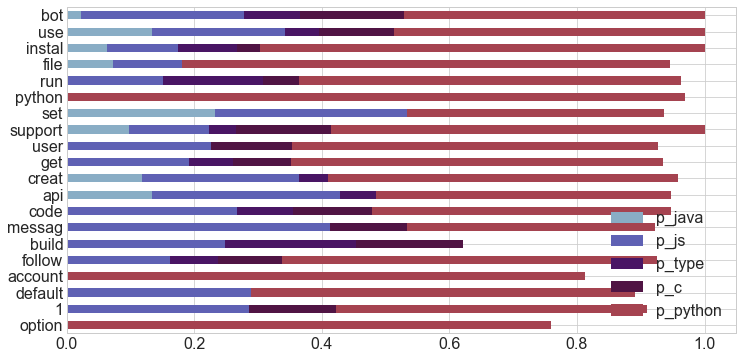

In [78]:
# All
(word_counts_no_freq
 .assign(p_java = word_counts_no_freq.java_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_js =word_counts_no_freq.js_word_cnt/ word_counts_no_freq['all_word_cnt'],
         p_type = word_counts_no_freq.type_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_c = word_counts_no_freq.c_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_python = word_counts_no_freq.python_word_cnt / word_counts_no_freq['all_word_cnt'])
 .sort_values(by='all_word_cnt')
 [['p_java', 'p_js','p_type', 'p_c', 'p_python']]
 .tail(20)
 #.sort_values(p_python)
 .plot.barh(stacked=True))

<AxesSubplot:>

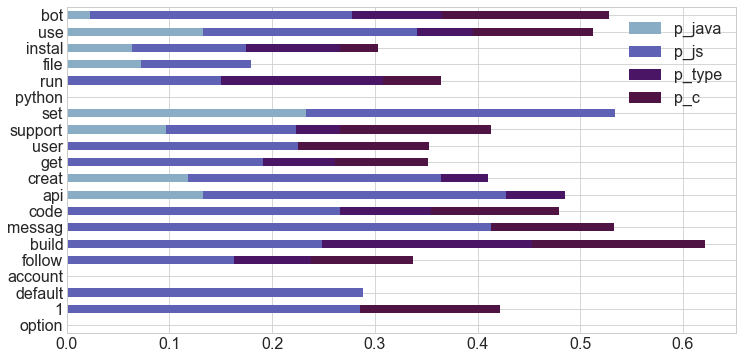

In [79]:
# No python
(word_counts_no_freq
 .assign(p_java = word_counts_no_freq.java_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_js =word_counts_no_freq.js_word_cnt/ word_counts_no_freq['all_word_cnt'],
         p_type = word_counts_no_freq.type_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_c = word_counts_no_freq.c_word_cnt / word_counts_no_freq['all_word_cnt'])
         #p_python = word_counts_no_freq.python_word_cnt / word_counts_no_freq['all_word_cnt'])
 .sort_values(by='all_word_cnt')
 [['p_java', 'p_js','p_type', 'p_c']]
 .tail(20)
 #.sort_values(p_python)
 .plot.barh(stacked=True))

# takeaway
- Account only appeersin python
- default only in JavaScript
- Java mentions bot the least

<AxesSubplot:>

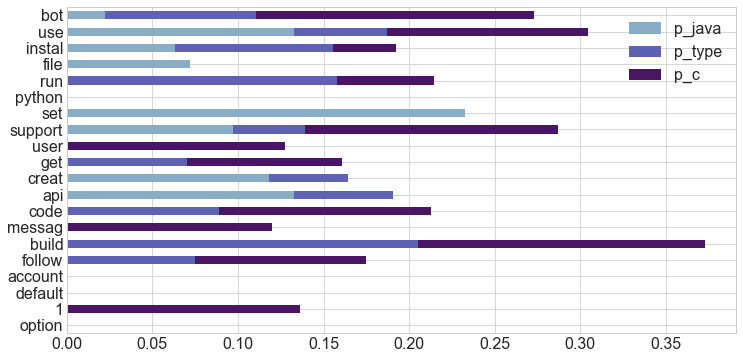

In [81]:
# No java script
(word_counts_no_freq
 .assign(p_java = word_counts_no_freq.java_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_type = word_counts_no_freq.type_word_cnt / word_counts_no_freq['all_word_cnt'],
         p_c = word_counts_no_freq.c_word_cnt / word_counts_no_freq['all_word_cnt'])
 .sort_values(by='all_word_cnt')
 [['p_java', 'p_type', 'p_c']]
 .tail(20)
 #.sort_values(p_python)
 .plot.barh(stacked=True))